In [1]:
#!pip install kagglehub
#!pip install pandas
#!pip install nltk
#!pip install transformers[torch] 
#!pip install emoji
#!pip install datasets 
#!pip install scikit-learn 
#!pip install evaluate
#!pip install py-cpuinfo gputil psutil
#!pip install svgling
#!pip install benepar

In [2]:
# Imports Dataset Kaggle
import kagglehub
# Download latest version
path = kagglehub.dataset_download("mariumfaheem666/spam-sms-classification-using-nlp")+"/"+"Spam_SMS.csv"

In [3]:
import nltk
import re
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import benepar
from nltk import Tree
import emoji
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

nltk.download('punkt')
parser = benepar.Parser("benepar_en3")
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Definição de Classes
class Mensagem:
    def __init__(self, mensagem_original, classificacao):
        self.MensagemOriginal = mensagem_original
        self.Classificacao = classificacao
        self.ClassificacaoInt = 1 if classificacao == 'spam' else 0

        #variável temporária para tratamentos
        text = self.MensagemOriginal
        text = emoji.demojize(text, language='en')
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = text.encode("utf-8", "ignore").decode()  
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\s+', ' ', text)
        sentences = sent_tokenize(text)
        cleaned_sentences = [s.strip() for s in sentences]
        
        # Msg Tratada (limpa)
        self.MensagemTratada = ' '.join(cleaned_sentences)     
        self.MensagemTokenizada = word_tokenize(self.MensagemTratada)
        self.QuantidadeCaracteres = len(self.MensagemTratada)
        self.QuantidadePalavras = len(self.MensagemTokenizada)

        tagged = pos_tag(self.MensagemTokenizada)
        verbs = [word for word, tag in tagged if tag.startswith('VB')]
        self.QuantidadeVerbos = len(verbs)
        nouns = [word for word, tag in tagged if tag.startswith('NN')]
        self.QuantidadeSubstantivos = len(nouns)
        
class BaseMensagens:
    def __init__(self, listamsgs):
        self.BaseMensagens = []
        for index, row in listamsgs.iterrows():
            self.BaseMensagens.append(Mensagem(row['Message'],row['Class']))
        self.BaseMensagensDataFrame = pd.DataFrame([{'text': p.MensagemTratada, 'target': p.ClassificacaoInt} for p in self.BaseMensagens])

    def Exec(self, percent):
        train_X, test_X, train_Y, test_Y = train_test_split(self.BaseMensagensDataFrame['text'], self.BaseMensagensDataFrame['target'], train_size = percent, shuffle = True)
        train_tokens = tokenizer(list(train_X), padding = True, truncation=True)
        test_tokens = tokenizer(list(test_X), padding = True, truncation=True)
        return BaseTreinamento(train_X, train_tokens, train_Y), BaseTeste(test_X, test_tokens, test_Y)

class BaseTreinamento(Dataset):
    def __init__(self, X, tokens, Y):
        self.text_data = X
        self.tokens = tokens
        self.labels = list(Y)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample

class BaseTeste(Dataset):
    def __init__(self, X, tokens, Y):
        self.text_data = X
        self.tokens = tokens
        self.labels = list(Y)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample

class BertHandler:
    def __init__(self, train, test, p_batch_size = 40, bert_pretrained_model = 'bert-base-cased'):
        self.batch_size = p_batch_size
        self.train_loader = DataLoader(train, shuffle=True, batch_size=self.batch_size)
        self.test_loader = DataLoader(test, shuffle=True, batch_size=self.batch_size)
        self.bert_model = BertForSequenceClassification.from_pretrained(bert_pretrained_model) # Pre-trained model
        self.optimizer = AdamW(self.bert_model.parameters(), lr=1e-5) # Optimization function
        self.loss_fn = torch.nn.CrossEntropyLoss() # Loss function
        
    def PrintMachineSpecs(self):
        import platform
        import psutil
        import cpuinfo
        import GPUtil
        import subprocess
        
        # Informações do sistema operacional
        print("===== SISTEMA OPERACIONAL =====")
        print(f"Sistema: {platform.system()} {platform.release()}")
        print(f"Arquitetura: {platform.architecture()[0]}")
        print(f"Nome do computador: {platform.node()}")
        
        # Informações da CPU
        print("\n===== CPU =====")
        cpu_info = cpuinfo.get_cpu_info()
        print(f"Nome da CPU: {cpu_info['brand_raw']}")
        print(f"Núcleos físicos: {psutil.cpu_count(logical=False)}")
        print(f"Núcleos lógicos: {psutil.cpu_count(logical=True)}")
        print(f"Frequência atual: {psutil.cpu_freq().current / 1000:.2f} GHz")
        
        # Informações de memória RAM
        print("\n===== MEMÓRIA RAM =====")
        mem = psutil.virtual_memory()
        print(f"Total: {mem.total / (1024 ** 3):.2f} GB")
        result = subprocess.run(
            ['powershell.exe', '-Command',
             "Get-CimInstance Win32_PhysicalMemory | Measure-Object -Property Capacity -Sum | % { '{0:N2}' -f ($_.Sum / 1GB) }"],
            capture_output=True,
            text=True
        )
        print(f"RAM Física Total (via PowerShell): {result.stdout.strip()} GB")
        
        # Informações da GPU
        print("\n===== GPU =====")
        gpus = GPUtil.getGPUs()
        if gpus:
            for gpu in gpus:
                print(f"Nome: {gpu.name}")
                print(f"Memória Total: {gpu.memoryTotal} MB")
                print(f"Driver: {gpu.driver}")
                print(f"ID: {gpu.id}")
        else:
            print("Nenhuma GPU dedicada detectada.")

    def RunTrainAndTest(self, num_epochs = 1, p_batch_size = 40):
        from datetime import datetime
        self.batch_size = p_batch_size
        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        self.bert_model.to(device) # Transfer model to GPU if available
        print('##############################################################')
        print('############### BERT TRAINING AND TEST PROCESS ###############')
        print('##############################################################')
        print('')
        self.PrintMachineSpecs()
        print('')
        print("\n===== PARAMETERS =====")
        print('Epochs: '+str(num_epochs))
        print('Batch Size: '+str(self.batch_size))
        print('')
        begin = datetime.now()
        print('############### BEGIN: '+begin.strftime("%d/%m/%Y %H:%M:%S")+' ###############')
        for epoch in range(num_epochs):
            print('')
            print("############### EPOCH: ",(epoch + 1))
            # TRAINING BLOCK STARTS
            self.bert_model.train()
            for i,batch in enumerate(self.train_loader):    
                batch = {k: v.to(device) for k, v in batch.items()}
                
                # Setting the gradients to zero
                self.optimizer.zero_grad()
                
                # Passing the data to the model
                outputs = self.bert_model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
                
                # The logits will be used for measuring the loss
                pred = outputs.logits
                loss = self.loss_fn(pred, batch['labels'])
        
                # Calculating the gradient for the loss function
                loss.backward()
                
                # Optimizing the parameters of the bert model
                self.optimizer.step()
        
                # Calculating the running loss for logging purposes
                train_batch_loss = loss.item()
                train_last_loss = train_batch_loss / self.batch_size
        
                print('Training batch {} last loss: {}'.format(i + 1, train_last_loss))
            # Logging epoch-wise training loss
            print(f"\nTraining epoch {epoch + 1} loss: ",train_last_loss)
            # TRAINING BLOCK ENDS 
            
            # TESTING BLOCK STARTS
            self.bert_model.eval()
            correct = 0
            test_pred = []
            for i, batch in enumerate(self.test_loader):
                batch = {k: v.to(device) for k, v in batch.items()}
                
                # We don't need gradients for testing
                with torch.no_grad():
                    outputs = self.bert_model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
                
                # Logits act as predictions
                logits = outputs.logits
                
                # Calculating total batch loss using the logits and labels
                loss = self.loss_fn(logits, batch['labels'])
                test_batch_loss = loss.item()
                
                # Calculating the mean batch loss
                test_last_loss = test_batch_loss / self.batch_size
                print('Testing batch {} loss: {}'.format(i + 1, test_last_loss))
                
                # Comparing the predicted target with the labels in the batch
                correct += (logits.argmax(1) == batch['labels']).sum().item()
                print("Testing accuracy: ",correct/((i + 1) * self.batch_size))
            
            total_test_samples = len(self.test_loader.dataset)
            final_accuracy = correct / total_test_samples
            print(f"\nTesting epoch {epoch + 1} last loss: ",test_last_loss)
            print(f"Final Testing Accuracy (Epoch {epoch + 1}): {final_accuracy:.4f}")
            # TESTING BLOCK ENDS
        end = datetime.now()
        print('############### END: '+begin.strftime("%d/%m/%Y %H:%M:%S")+' ###############')
        elapsed_minutes = (end - begin).total_seconds() / 60
        print(f"############### TOTAL ELAPSED TIME: {elapsed_minutes:.2f} minutes ###############")

[nltk_data] Downloading package punkt to /home/aletyska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
spam_sms = pd.read_csv(path)

In [5]:
base = BaseMensagens(spam_sms)

In [6]:
def ArvoreSintagmatica(sentence: str):
    tokens = word_tokenize(sentence)
    tree = parser.parse(tokens)
    print(tree.pretty_print())
    return tree

def ArvoreSintagmaticaRecursao(tree: Tree, indent: int = 0):
    if isinstance(tree, str):
        # Leaf node (word)
        print('  ' * indent + tree)
    else:
        # Internal node (e.g., S, NP, VP)
        print('  ' * indent + tree.label())
        for child in tree:
            ArvoreSintagmaticaRecursao(child, indent + 1)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/home/aletyska/anaconda3/envs/tec_prog/lib/python3.12/site-packages/torch/distributions/distribution.py:56: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


                                                                  TOP                                                                     
                                                                   |                                                                       
                                                                   S                                                                      
  _________________________________________________________________|____________________________________________________________________   
 |          |               |                                ADJP                                  |        |              |            | 
 |          |               |     ____________________________|____                                |        |              |            |  
 |          |               |    |    |                           ADJP                             |        |              |            | 
 |          |           

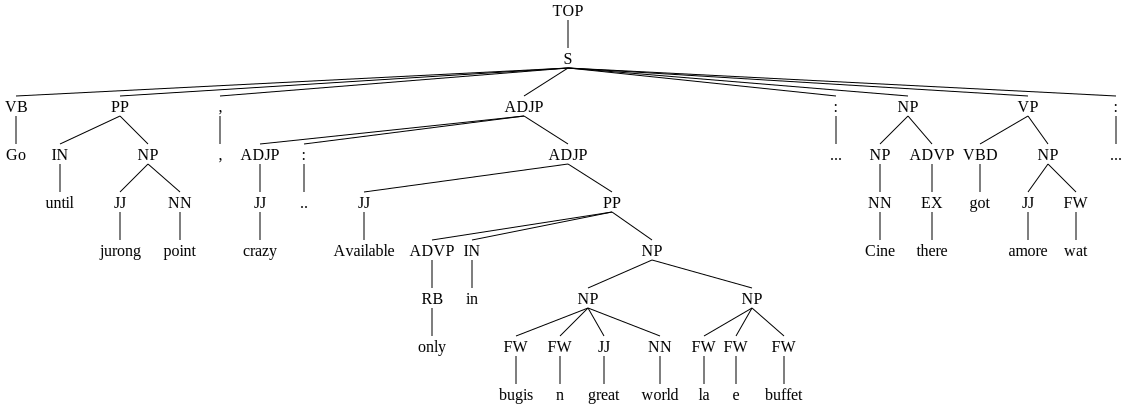

In [7]:
ArvoreSintagmatica(base.BaseMensagens[0].MensagemOriginal)

In [8]:
tree = ArvoreSintagmatica(base.BaseMensagens[0].MensagemOriginal)
ArvoreSintagmaticaRecursao(tree)

                                                                  TOP                                                                     
                                                                   |                                                                       
                                                                   S                                                                      
  _________________________________________________________________|____________________________________________________________________   
 |          |               |                                ADJP                                  |        |              |            | 
 |          |               |     ____________________________|____                                |        |              |            |  
 |          |               |    |    |                           ADJP                             |        |              |            | 
 |          |           

In [9]:
train, test = base.Exec(0.7)

In [10]:
bert = BertHandler(train, test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
bert.RunTrainAndTest(num_epochs=1, p_batch_size=40)

##############################################################
############### BERT TRAINING AND TEST PROCESS ###############
##############################################################

===== SISTEMA OPERACIONAL =====
Sistema: Linux 6.6.87.1-microsoft-standard-WSL2
Arquitetura: 64bit
Nome do computador: GAMING-SERVER

===== CPU =====
Nome da CPU: AMD Ryzen 7 2700 Eight-Core Processor
Núcleos físicos: 8
Núcleos lógicos: 16
Frequência atual: 3.39 GHz

===== MEMÓRIA RAM =====
Total: 15.58 GB
RAM Física Total (via PowerShell): 32,00 GB

===== GPU =====
Nome: NVIDIA GeForce RTX 3060
Memória Total: 12288.0 MB
Driver: 572.83
ID: 0


===== PARAMETERS =====
Epochs: 1
Batch Size: 40

############### BEGIN: 15/06/2025 15:12:43 ###############

############### EPOCH:  1
Training batch 1 last loss: 0.01688491404056549
Training batch 2 last loss: 0.014468967914581299
Training batch 3 last loss: 0.014773236215114593
Training batch 4 last loss: 0.014993014931678771
Training batch 5 last loss: 0.01